In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from scipy.sparse.csgraph import minimum_spanning_tree, shortest_path
from scipy.interpolate import splprep, splev

# =========================
# 1. Load data
# =========================
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R = np.load(NEURAL_PATH)
areas = np.load(AREAS_PATH, allow_pickle=True)

In [13]:
print(R.shape)

(39209, 118)


In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]  # shape (Nstim,)


In [8]:
# R: neurons × stimuli
# vit_pc1: stimuli

# Normalize vit_pc1 for safety
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# Compute correlations
# Vectorized: corr(n_i, v) for all neurons
R_centered = R - R.mean(axis=1, keepdims=True)
R_std = R.std(axis=1, keepdims=True) + 1e-8

corr = (R_centered @ v) / (R_std[:, 0] * (len(v)-1))


order = np.argsort(-corr)  # descending correlation
R_sorted = R[order]
areas_sorted = areas[order]
corr_sorted = corr[order]


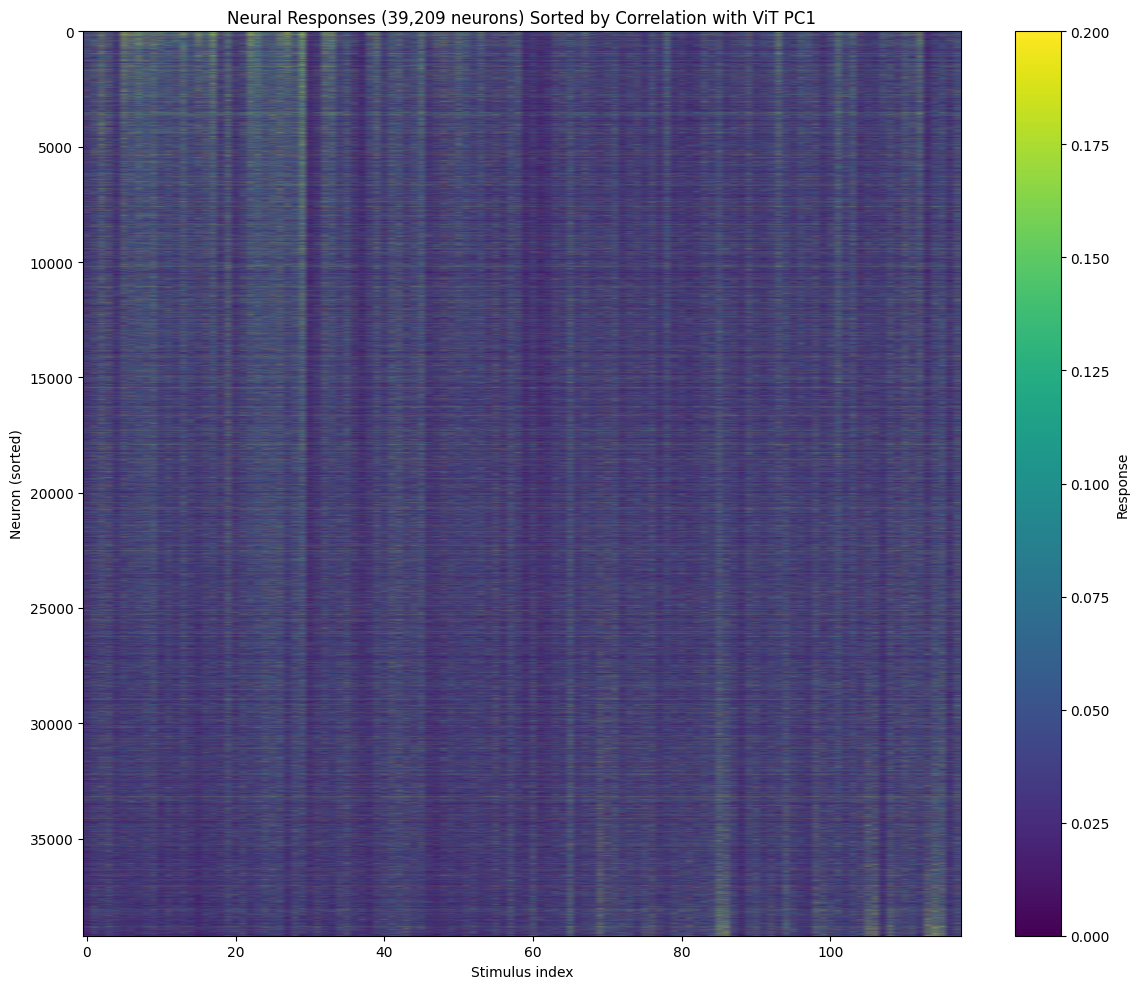

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.imshow(R_sorted, aspect='auto', cmap='viridis', vmin=0, vmax=0.2)
plt.colorbar(label='Response')
plt.title("Neural Responses (39,209 neurons) Sorted by Correlation with ViT PC1")
plt.xlabel("Stimulus index")
plt.ylabel("Neuron (sorted)")
plt.tight_layout()
plt.show()


In [14]:
print("vit:", vit.shape)
print("R:", R.shape)
print("areas:", areas.shape)


vit: (118, 1000)
R: (39209, 118)
areas: (39209,)


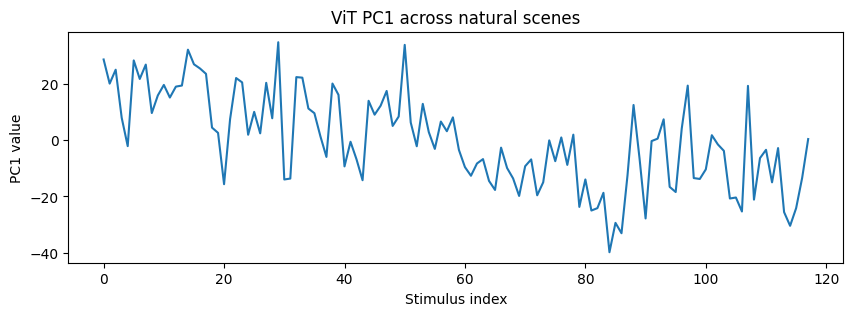

PC1 variance: 276.7664
Correlation min: -0.3754052053576393
Correlation max: 0.469962130163488
Correlation std: 0.10471424399201207


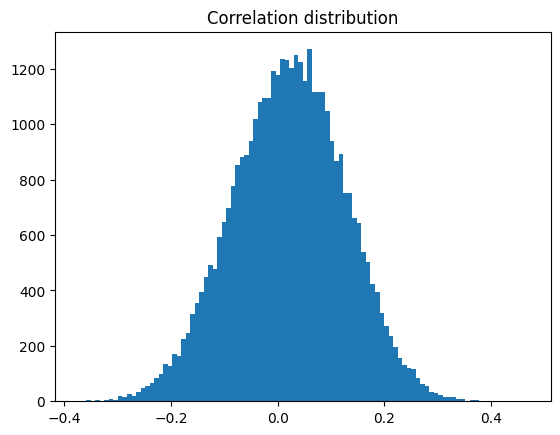

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- PCA on ViT logits ---
pca = PCA(n_components=10)
pcs = pca.fit_transform(vit)  # (118 stimulus frames × 10 PCs)
vit_pc1 = pcs[:, 0]

# --- Plot PC1 ---
plt.figure(figsize=(10,3))
plt.plot(vit_pc1)
plt.title("ViT PC1 across natural scenes")
plt.xlabel("Stimulus index")
plt.ylabel("PC1 value")
plt.show()

# --- Correlations ---
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

Rz = (R - R.mean(axis=1, keepdims=True)) / (R.std(axis=1, keepdims=True) + 1e-8)
corr = (Rz @ v) / len(v)

print("PC1 variance:", vit_pc1.var())
print("Correlation min:", corr.min())
print("Correlation max:", corr.max())
print("Correlation std:", corr.std())

plt.hist(corr, bins=100)
plt.title("Correlation distribution")
plt.show()


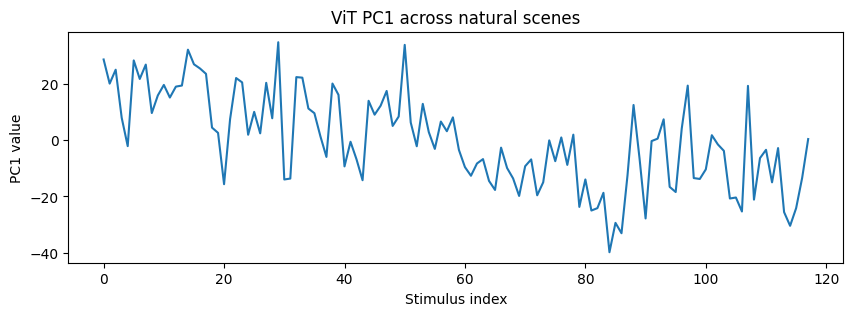

PC1 variance: 276.7664
Correlation min: -0.3754052053576393
Correlation max: 0.469962130163488
Correlation std: 0.10471424399201207


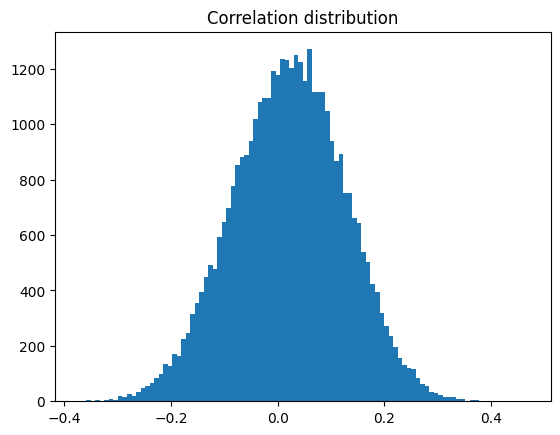

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- PCA on ViT logits ---
pca = PCA(n_components=10)
pcs = pca.fit_transform(vit)  # (118 stimulus frames × 10 PCs)
vit_pc1 = pcs[:, 0]

# --- Plot PC1 ---
plt.figure(figsize=(10,3))
plt.plot(vit_pc1)
plt.title("ViT PC1 across natural scenes")
plt.xlabel("Stimulus index")
plt.ylabel("PC1 value")
plt.show()

# --- Correlations ---
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

Rz = (R - R.mean(axis=1, keepdims=True)) / (R.std(axis=1, keepdims=True) + 1e-8)
corr = (Rz @ v) / len(v)

print("PC1 variance:", vit_pc1.var())
print("Correlation min:", corr.min())
print("Correlation max:", corr.max())
print("Correlation std:", corr.std())

plt.hist(corr, bins=100)
plt.title("Correlation distribution")
plt.show()


corr range: -0.37540514108057027 0.4699622204983685 std: 0.10471425083156731


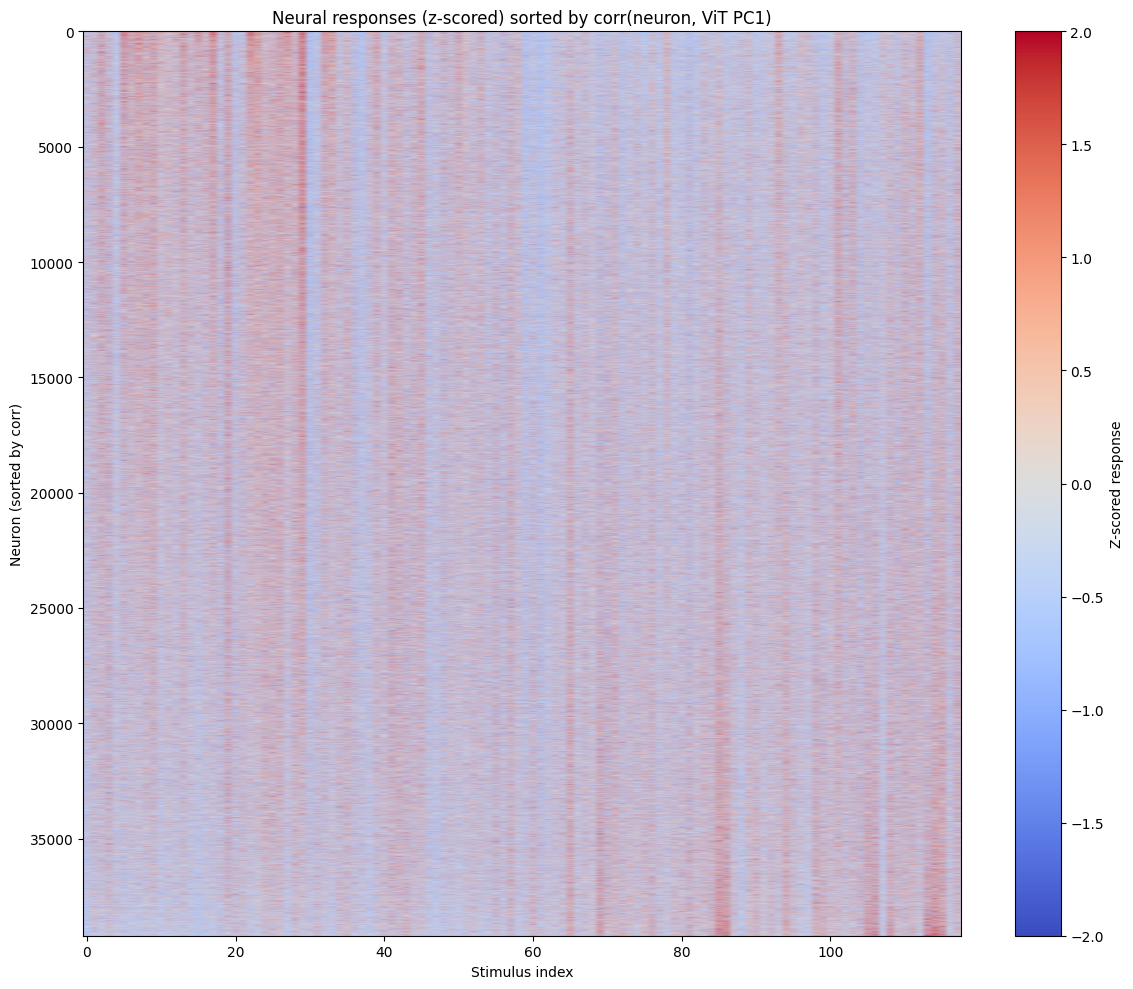

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --- PCA on ViT logits (already good) ---
pca = PCA(n_components=10)
pcs = pca.fit_transform(vit)  # (118, 10)
vit_pc1 = pcs[:, 0]

# z-score PC1 for correlations
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# --- z-score neural responses per neuron (important!) ---
Rz = (R - R.mean(axis=1, keepdims=True)) / (R.std(axis=1, keepdims=True) + 1e-8)

# --- correlations using z-scored R ---
corr = (Rz @ v) / len(v)   # shape (39209,)

print("corr range:", corr.min(), corr.max(), "std:", corr.std())

order_neurons = np.argsort(-corr)     # descending correlation
Rz_sorted = Rz[order_neurons]

plt.figure(figsize=(12, 10))
plt.imshow(
    Rz_sorted,
    aspect="auto",
    cmap="coolwarm",
    vmin=-2, vmax=2  # symmetric scale to show +/- deviations
)
plt.colorbar(label="Z-scored response")
plt.title("Neural responses (z-scored) sorted by corr(neuron, ViT PC1)")
plt.xlabel("Stimulus index")
plt.ylabel("Neuron (sorted by corr)")
plt.tight_layout()
plt.show()


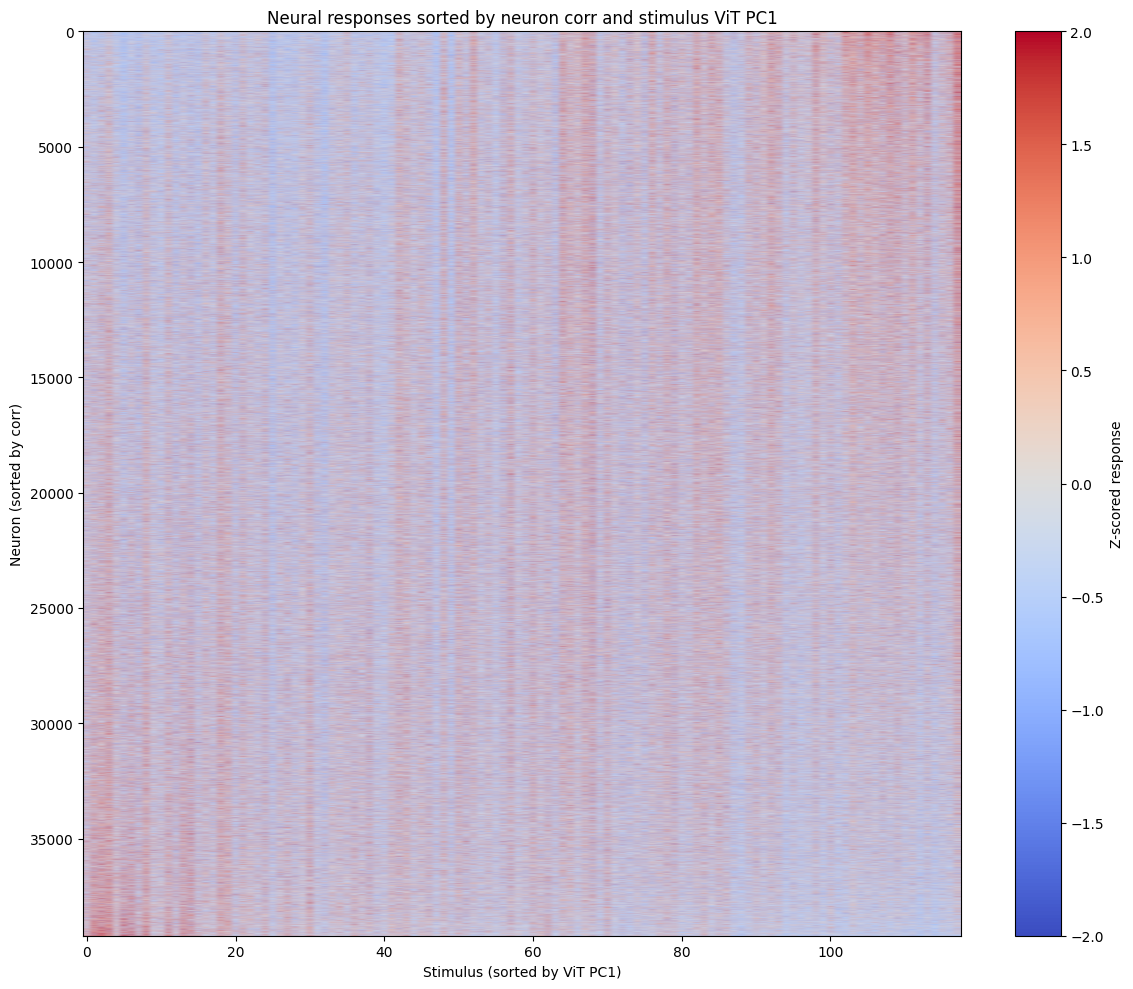

In [17]:
order_neurons = np.argsort(-corr)          # y-axis: neuron preference for PC1
order_stim    = np.argsort(vit_pc1)        # x-axis: stimulus PC1 value

Rz_sorted2 = Rz[order_neurons][:, order_stim]

plt.figure(figsize=(12, 10))
plt.imshow(
    Rz_sorted2,
    aspect="auto",
    cmap="coolwarm",
    vmin=-2, vmax=2
)
plt.colorbar(label="Z-scored response")
plt.title("Neural responses sorted by neuron corr and stimulus ViT PC1")
plt.xlabel("Stimulus (sorted by ViT PC1)")
plt.ylabel("Neuron (sorted by corr)")
plt.tight_layout()
plt.show()


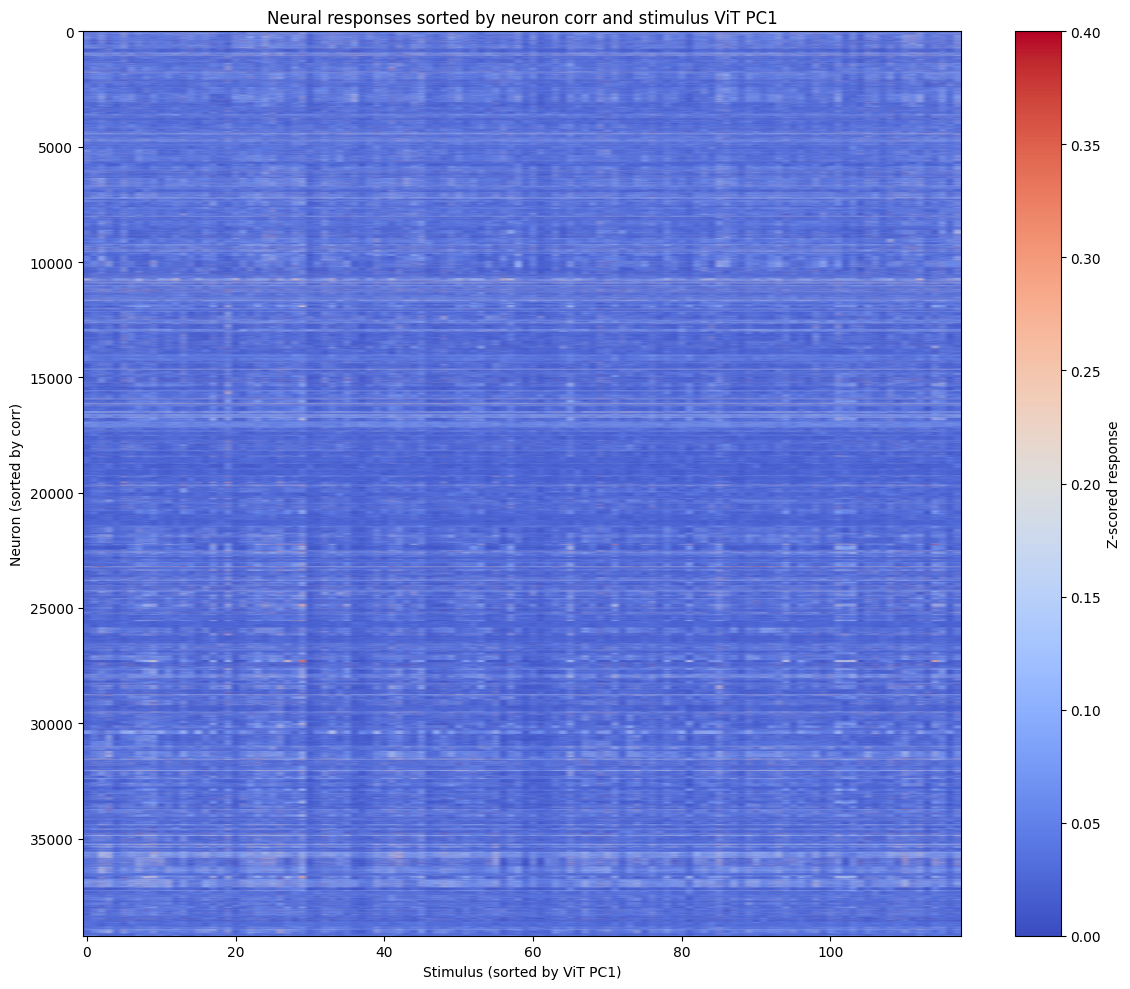

In [20]:

plt.figure(figsize=(12, 10))
plt.imshow(
    R,
    aspect="auto",
    cmap="coolwarm",
    vmin=0, vmax=0.4
)
plt.colorbar(label="Z-scored response")
plt.title("Neural responses sorted by neuron corr and stimulus ViT PC1")
plt.xlabel("Stimulus (sorted by ViT PC1)")
plt.ylabel("Neuron (sorted by corr)")
plt.tight_layout()
plt.show()

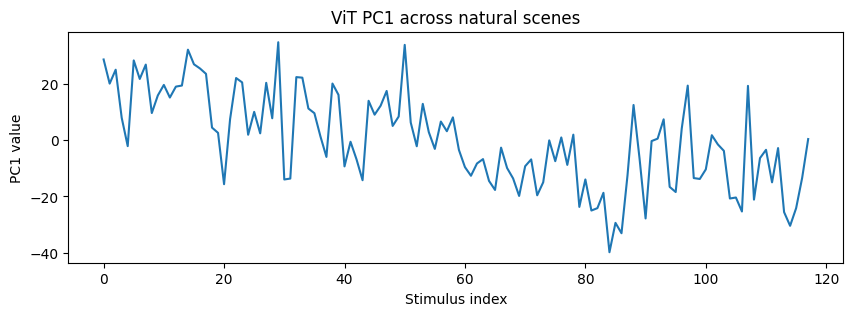

PC1 variance: 276.7664
Correlation min: -0.3754052053576393
Correlation max: 0.469962130163488
Correlation std: 0.10471424399201207


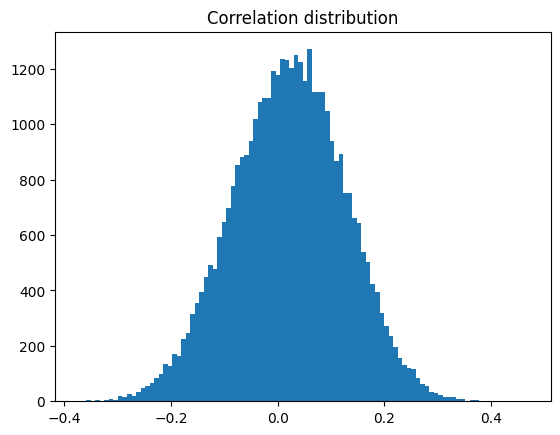

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# --- PCA on ViT logits ---
pca = PCA(n_components=10)
pcs = pca.fit_transform(vit)  # (118 stimulus frames × 10 PCs)
vit_pc1 = pcs[:, 0]

# --- Plot PC1 ---
plt.figure(figsize=(10,3))
plt.plot(vit_pc1)
plt.title("ViT PC1 across natural scenes")
plt.xlabel("Stimulus index")
plt.ylabel("PC1 value")
plt.show()

# --- Correlations ---
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

Rz = (R - R.mean(axis=1, keepdims=True)) / (R.std(axis=1, keepdims=True) + 1e-8)
corr = (Rz @ v) / len(v)

print("PC1 variance:", vit_pc1.var())
print("Correlation min:", corr.min())
print("Correlation max:", corr.max())
print("Correlation std:", corr.std())

plt.hist(corr, bins=100)
plt.title("Correlation distribution")
plt.show()


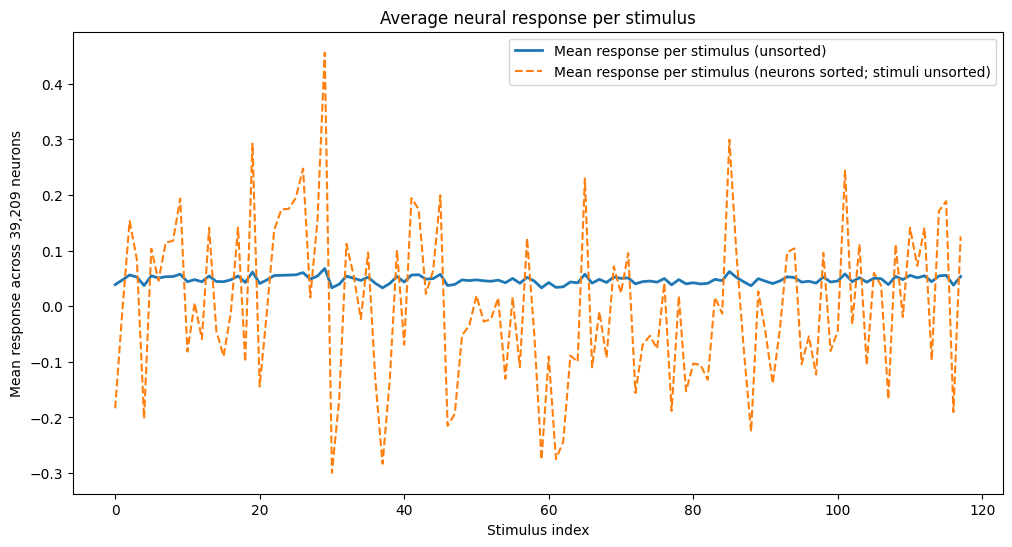

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Unsorted mean response per stimulus
mean_unsorted = R.mean(axis=0)

# 2. Sorted mean response per stimulus (still sorted along neuron axis)
# Note: Rz_sorted2 was neuron-sorted and stimulus-sorted; use the one before x-sort
mean_sorted = Rz_sorted.mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_unsorted, label="Mean response per stimulus (unsorted)", linewidth=2)
plt.plot(mean_sorted, label="Mean response per stimulus (neurons sorted; stimuli unsorted)", linestyle='--')
plt.title("Average neural response per stimulus")
plt.xlabel("Stimulus index")
plt.ylabel("Mean response across 39,209 neurons")
plt.legend()
plt.show()


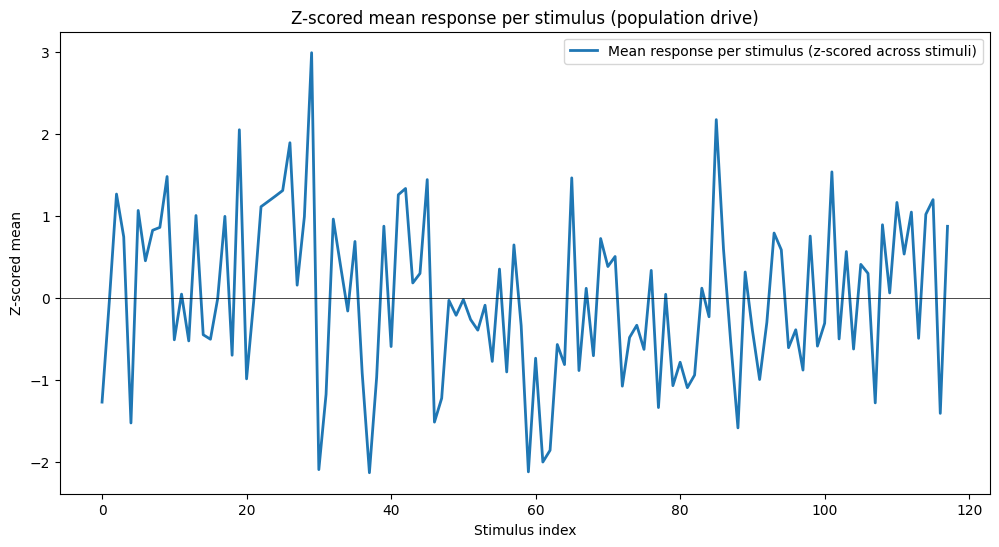

In [23]:
mean_unsorted = R.mean(axis=0)
mean_unsorted_z = (mean_unsorted - np.mean(mean_unsorted)) / np.std(mean_unsorted)

plt.figure(figsize=(12,6))
plt.plot(mean_unsorted_z, label="Mean response per stimulus (z-scored across stimuli)", linewidth=2)
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Z-scored mean response per stimulus (population drive)")
plt.xlabel("Stimulus index")
plt.ylabel("Z-scored mean")
plt.legend()
plt.show()


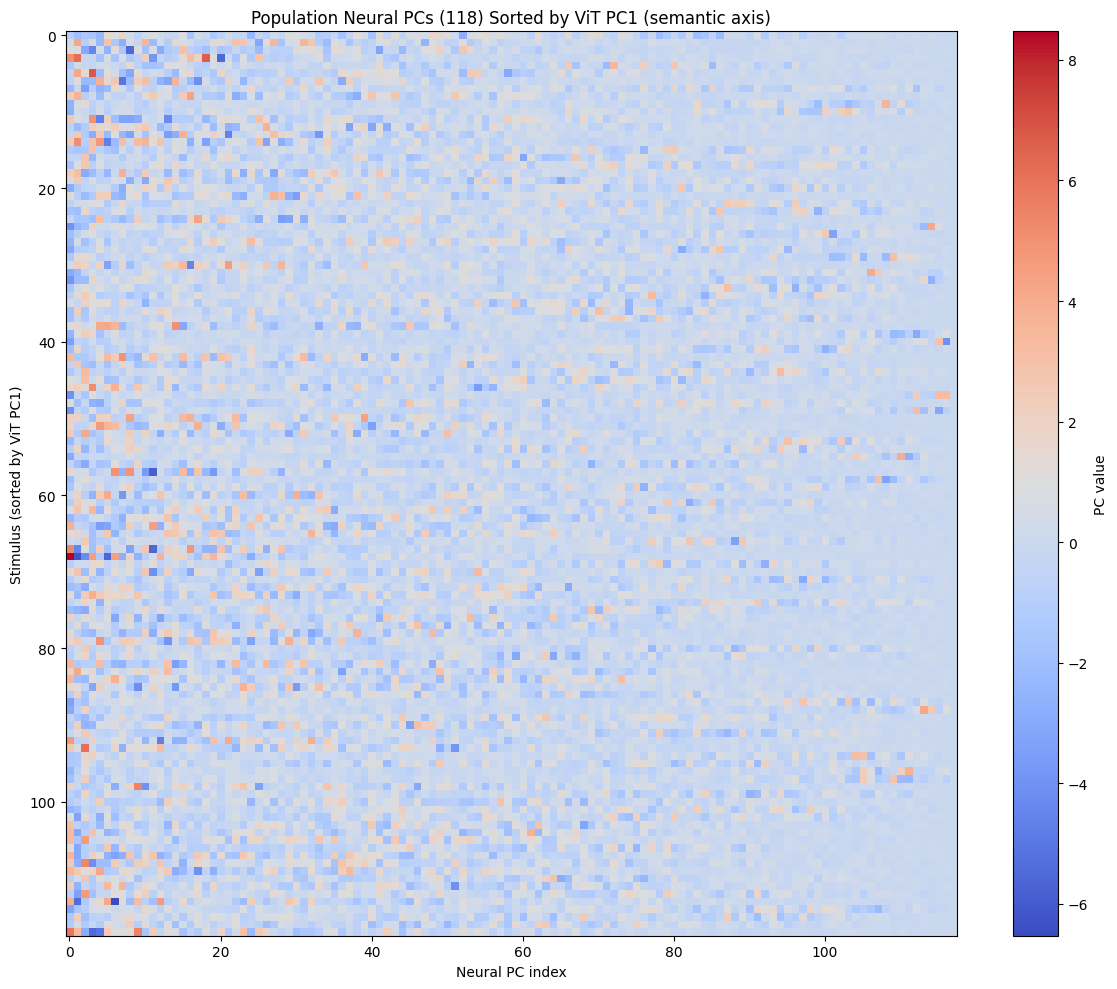

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# R: (neurons × stimuli) = (39209 × 118)

# --- Step 1: PCA across neurons ---
# We want to find population components that vary across stimuli
# So we PCA the transposed matrix: shape (118 stimuli × 39209 neurons)

pca_neural = PCA(n_components=118)
PC_activity = pca_neural.fit_transform(R.T)   # shape (118 stimuli × 118 PCs)

# Optional: standardize rows if needed
# PC_activity = (PC_activity - PC_activity.mean(axis=0)) / PC_activity.std(axis=0)

# --- Step 2: Sort stimuli by ViT semantic axis ---
pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]

order_stim = np.argsort(vit_pc1)            # ascending semantic axis
PC_sorted = PC_activity[order_stim]         # reorder stimuli

# --- Step 3: Plot heatmap of all 118 population PCs ---
plt.figure(figsize=(12, 10))
plt.imshow(PC_sorted, aspect='auto', cmap='coolwarm')
plt.colorbar(label="PC value")

plt.title("Population Neural PCs (118) Sorted by ViT PC1 (semantic axis)")
plt.xlabel("Neural PC index")
plt.ylabel("Stimulus (sorted by ViT PC1)")

plt.tight_layout()
plt.show()


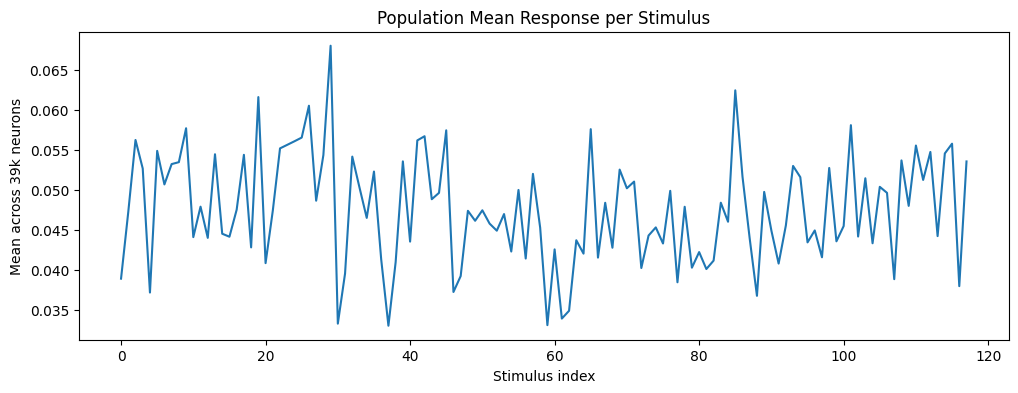

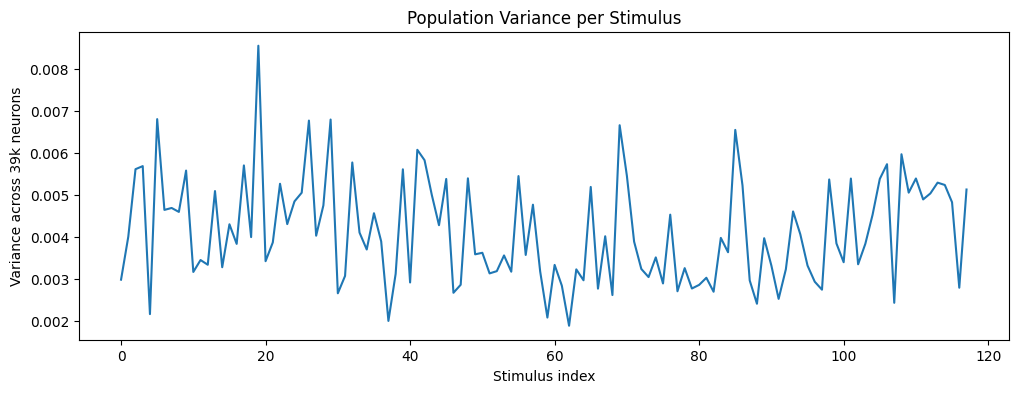

In [25]:
mean_per_stim = R.mean(axis=0)      # shape (118,)
var_per_stim  = R.var(axis=0)       # shape (118,)

plt.figure(figsize=(12,4))
plt.plot(mean_per_stim)
plt.title("Population Mean Response per Stimulus")
plt.xlabel("Stimulus index")
plt.ylabel("Mean across 39k neurons")
plt.show()

plt.figure(figsize=(12,4))
plt.plot(var_per_stim)
plt.title("Population Variance per Stimulus")
plt.xlabel("Stimulus index")
plt.ylabel("Variance across 39k neurons")
plt.show()


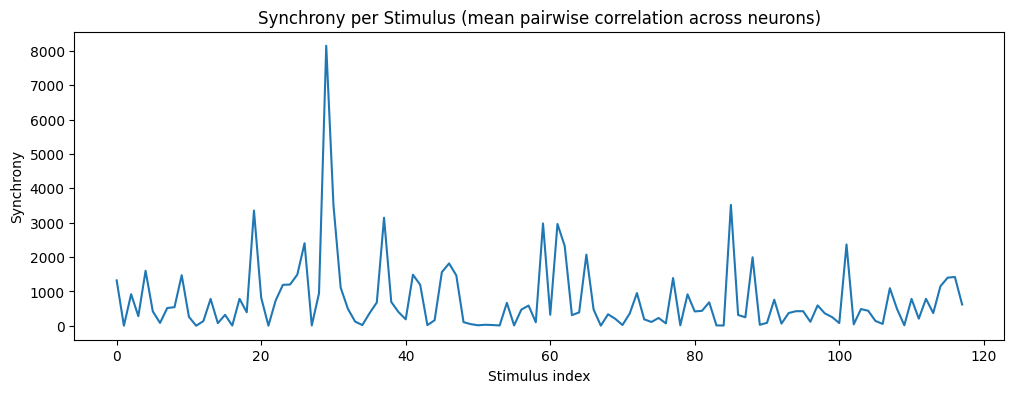

In [26]:
# z-score neurons across stimuli
Rz = (R - R.mean(axis=1, keepdims=True)) / (R.std(axis=1, keepdims=True)+1e-8)

# Stimulus-wise synchrony = mean pairwise correlation across neurons
# We compute the covariance of the neuron vector for each stimulus
synchrony = np.einsum('is,js->s', Rz, Rz) / R.shape[0]

plt.figure(figsize=(12,4))
plt.plot(synchrony)
plt.title("Synchrony per Stimulus (mean pairwise correlation across neurons)")
plt.xlabel("Stimulus index")
plt.ylabel("Synchrony")
plt.show()
